In [1]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pickle as pkl
import skimage
import yaml
import pandas as pd

import sys
sys.path.append('../cytof/')
from hyperion_analysis import batch_generate_summary, \
co_expression_analysis, correlation_analysis, interaction_analysis
from classes import CytofCohort
from utils import load_CytofCohort

## Parameters

In [29]:
class options:
    def __init__(self):
        self.cohort_file    = "/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/github/image_cytof_test_data/hyperion/cohort1/test_cohort.csv" 
        self.outdir         = "../test_out/cohort/test_cohort/test_cohort"
        self.normq          = 99
        self.feature_type   = "normed_scaled" # choose from "normed_scaled", "normed", ""
        # self.vis_quantile_q = 0.9
        self.cohort_out    = "cytof_cohort.pkl"
params = options()

## Load CytofCohort object

In [41]:
# cytof_cohort = CytofCohort(file_cohort=params.cohort_file, 
#                            file_io=os.path.join(params.outdir,'input_output.csv'), 
#                            dir_out=params.outdir)

## load existing CytofCohort

cytof_cohort = load_CytofCohort(os.path.join(params.outdir, "cytof_cohort.pkl"))

In [69]:
cytof_cohort.cytof_imgs['NP39264_B3_TM16MAR20_NP39264_b3_ROI_002_2'].features.keys()

dict_keys(['nuclei_morphology', 'cell_morphology', 'cell_sum', 'cell_ave', 'nuclei_sum', 'nuclei_ave'])

In [75]:
cytof_cohort.dir_out

'../test_out/cohort/test_cohort/test_cohort'

In [73]:
cytof_cohort.df_io['output_file'].unique()

array(['/endosome/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/github/image_cytof/test_out/cohort/test_cohort/test_cohort/cytof_images/NP39264_B3_TM16MAR20_NP39264_b3_ROI_002_2.pkl',
       '/endosome/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/github/image_cytof/test_out/cohort/test_cohort/test_cohort/cytof_images/NP39264_B3_TM16MAR20_NP39264_b3_ROI_001_1.pkl',
       '/endosome/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/github/image_cytof/test_out/cohort/test_cohort/test_cohort/cytof_images/NP39264_B3_TM16MAR20_NP39264_b3_ROI_003_3.pkl',
       '/endosome/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/github/image_cytof/test_out/cohort/test_cohort/test_cohort/cytof_images/NP37646_B5_TM14MAR20_NP37646_B5_ROI_001B_9.pkl',
       '/endosome/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/github/image_cytof/test_out/cohort/test_cohort/test_cohort/cytof_images/NP37646_B5_TM14MAR20_NP37646_B5_ROI_003_3.pkl',
       '/endosome/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/github/image_cytof/test_out

In [71]:
cytof_cohort.df_cohort['path'].unique()

array(['/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/github/image_cytof_test_data/hyperion/cohort1/NP39264_B3',
       '/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/github/image_cytof_test_data/hyperion/cohort1/NP37646_B5'],
      dtype=object)

In [58]:
cytof_cohort.dict_feat.keys()

dict_keys(['nuclei_morphology', 'cell_morphology', 'cell_sum', 'cell_ave', 'nuclei_sum', 'nuclei_ave'])

In [54]:
dir(cytof_cohort) # .cytof_imgs['NP39264_B3_TM16MAR20_NP39264_b3_ROI_002_2']

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_gather_roi_kneighbor_graphs',
 '_gather_roi_pheno',
 'attach_individual_roi',
 'cluster_interaction_analysis',
 'clustering_phenograph',
 'cytof_imgs',
 'df_cohort',
 'df_io',
 'dict_feat',
 'dir_out',
 'feat_sets',
 'get_feature',
 'get_images',
 'get_set_feature',
 'markers',
 'save_cytof_cohort',
 'vis_phenograph']

## Thresholding and generate cell count summary
`generate_summary` (`_get_thresholds`)

### 1) Calculate thresholds and generate cell count summary

Save output to: ../test_out/cohort/test_cohort/test_cohort/marker_summary/99normed_scaled

The attribute name of the feature: df_feature_99normed_scaled
Getting thresholds for marker sum


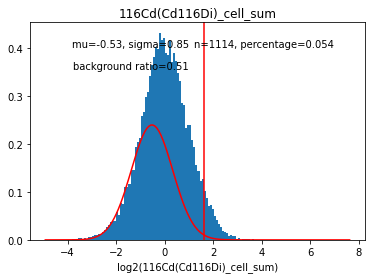

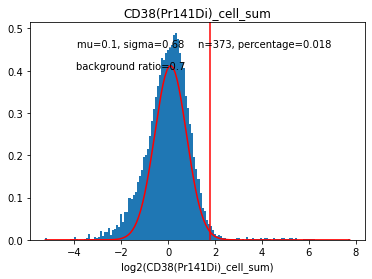

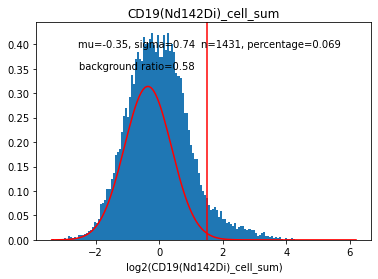

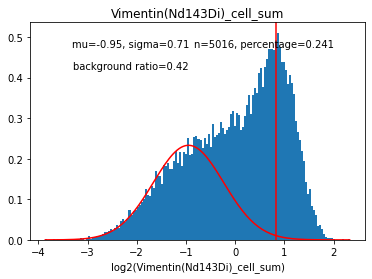

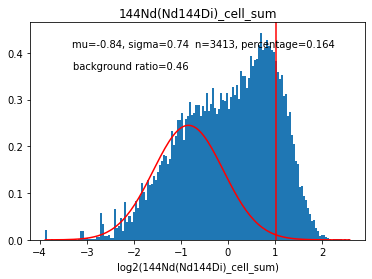

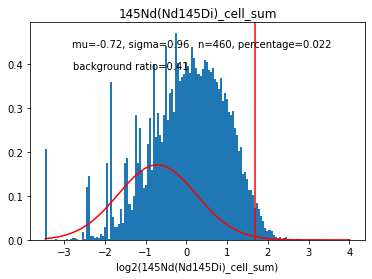

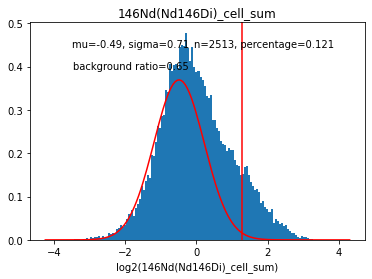

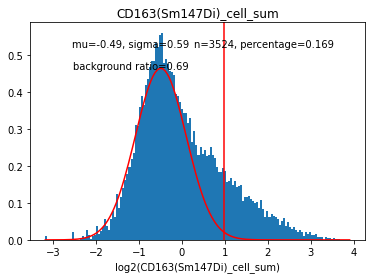

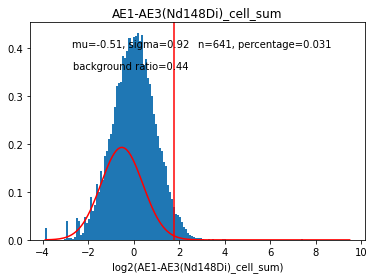

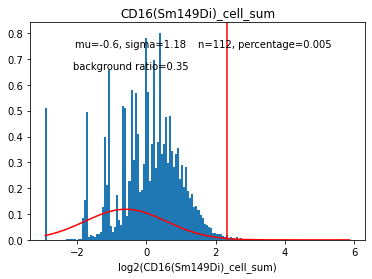

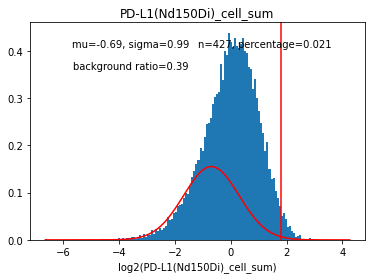

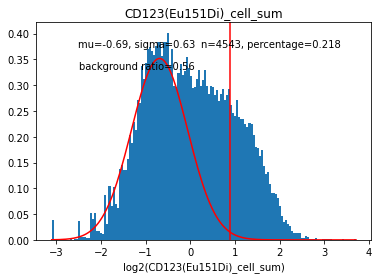

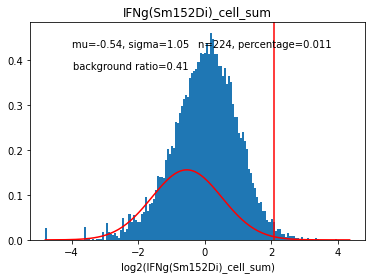

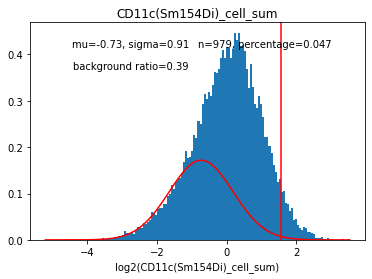

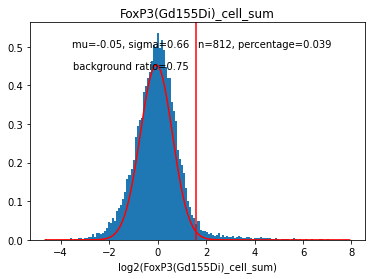

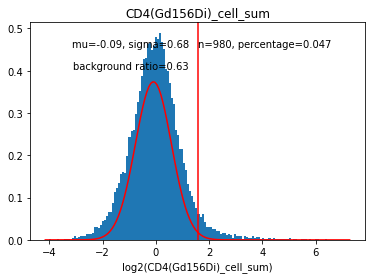

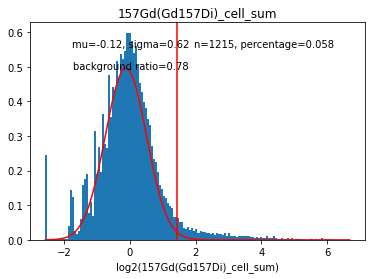

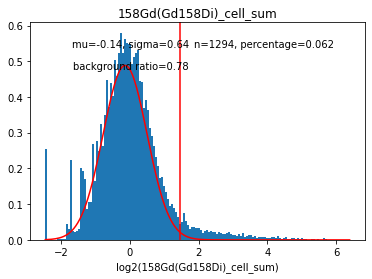

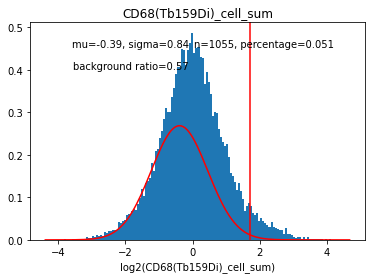

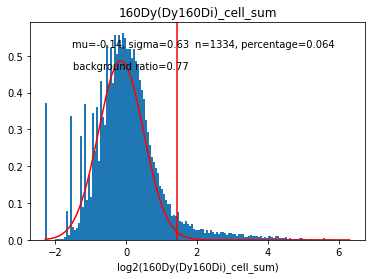

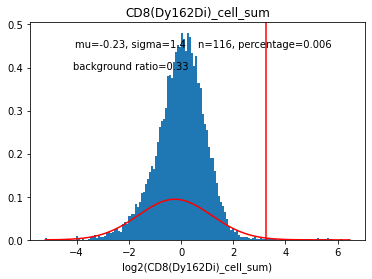

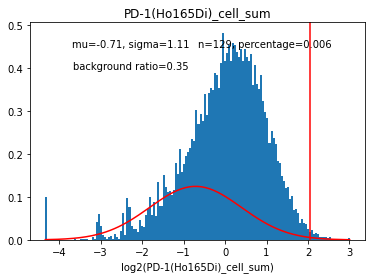

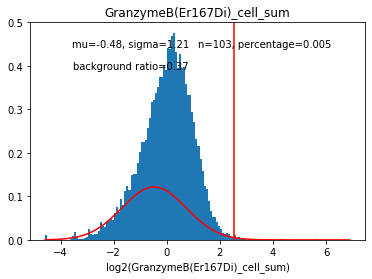

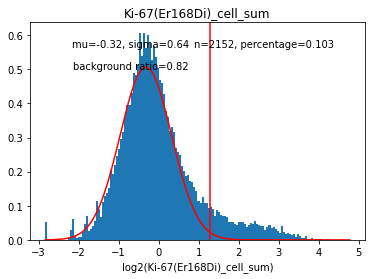

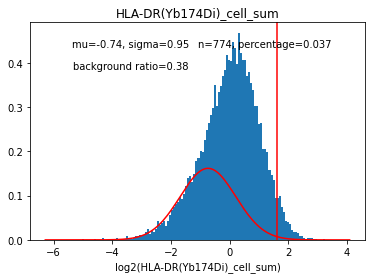

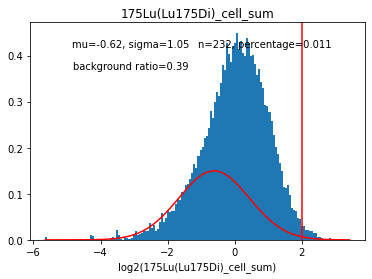

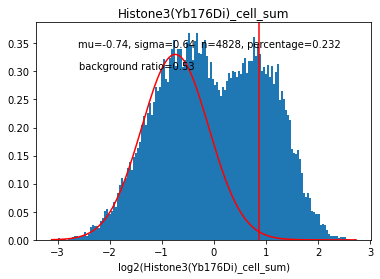

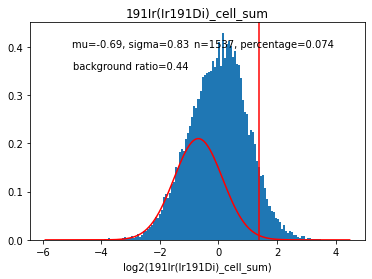

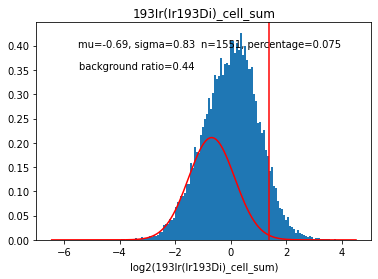

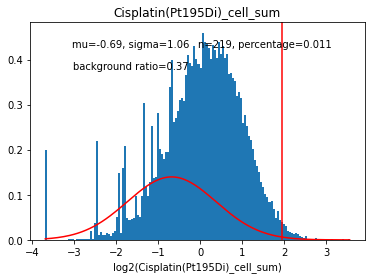

KeyError: '99_normed_scaled'

In [63]:
from hyperion_analysis import _get_thresholds
def generate_summary(self, 
                     feat_type: str = "normed", 
                     normq: int = 75, 
                     vis_thres: bool = False, 
                     verbose: bool = False):
    """ Generate marker positive summary for the cohort
    Inputs:
        outdir       = output saving directory, which contains the scale file generated previously, as well as previously saved
                     cytof_img class instances in .pkl files
        feature_type = type of feature to be used, available choices: "original", "normed", "scaled"
        normq        = q value of quantile normalization
        scaled       = a flag indicating whether or not use the scaled version of features (Default=False)
        vis_thres    = a flag indicating whether or not visualize the process of calculating thresholds (Default=False)
    Outputs: None
        Two .csv files, one for cell sum and the other for cell average features, are saved for each ROI, containing the
        threshold and cell count information of each feature, in the subfolder "marker_summary" under outdir
    """
    assert feat_type in ["normed_scaled", "normed", ""], f"feature type {feat_type} not supported!"
    feat_name = f"{feat_type}" if feat_type=="" else f"{normq}{feat_type}" # the attribute name to achieve from cytof_img
    n_attr = f"df_feature{feat_name}" if feat_type=="" else f"df_feature_{feat_name}" # the attribute name to achieve from cytof_img
    
    dir_sum = os.path.join(self.dir_out, "marker_summary", feat_name)
    print(f"Save output to: {dir_sum}")
    if not os.path.exists(dir_sum):
        os.makedirs(dir_sum)
    
    if not hasattr(self, n_attr):
        self.get_feature(normq, feat_type)
    if verbose:
        print("\nThe attribute name of the feature: {}".format(n_attr))
    all_df = getattr(self, n_attr)

    thres = getattr(self, "marker_thresholds", {})
    for _ in ["sum", "ave"]:
        print(f"Getting thresholds for marker {_}")
#         feat = all_df[self.dict_feat[f"cell_{_}"]]
        thres[f"{normq}_{feat_type}"][f"cell_{_}"] = _get_thresholds(feature_summary_df=all_df, 
                                                                     features=self.dict_feat[f"cell_{_}"], 
                                                                     visualize=vis_thres)
    import pdb; pdb.set_trace()
    # setattr(self, "marker_thresholds", thresholds)
    
    # split to each ROI
    self.get_images()
    for f, cytof_img in self.cytofs.items():
        f_roi = os.path.basename(f).split(".pkl")[0]
        _df = getattr(cytof_img, n_attr)
        for _ in ["sum", "ave"]:
            df_info_cell_x_f = generate_summary(_df, 
                                                  features=self.dict_feat[f"cell_{_}"],
                                                  thresholds=thres[f"cell_{_}"])
            df_info_cell_x_f.to_csv(os.path.join(dir_sum, f"{f_roi}_cell_count_{_}.csv"), index=False)
#             df_info_cell_ave_f = generate_summary(_df, features=feat_cell_ave, thresholds=thres_ave)
#         setattr(cytof_img, f"cell_count_{feat_name}_sum", df_info_cell_sum_f)
#         setattr(cytof_img, f"cell_count_{feat_name}_ave", df_info_cell_ave_f)
#         df_info_cell_sum_f.to_csv(os.path.join(dir_sum, f"{f_roi}_cell_count_sum.csv"), index=False)
#         df_info_cell_ave_f.to_csv(os.path.join(dir_sum, f"{f_roi}_cell_count_ave.csv"), index=False)
#         pkl.dump(cytof_img, open(f, "wb"))        
#     return thres_sum, thres_ave

generate_summary(cytof_cohort, feat_type=params.feature_type, normq=params.normq, vis_thres=True, verbose=True)

In [3]:
dir_sum = batch_generate_summary(outdir=params.outdir, feature_type=params.feature_type, normq=params.normq, vis_thres=True)
print("Marker positive summary saved here: {}".format(dir_sum))

AssertionError: accepted feature types are "original", "normed", "scaled"

### 2) Visualize marker positive pixels on original image
`visualize_thresholding_outcome`

In [5]:
## load a previously saved CytofImage class object

from classes import load_saved_CytofImage

f = '{}/cytof_images/NP37646_B5_TM14MAR20_NP37646_B5_ROI_001B_9.pkl'.format(params.outdir)    # glob.glob(os.path.join(params.outdir, "*pkl"))[0]
cytof_img = load_saved_CytofImage(f) #pkl.load(open(f, "rb"))
f_roi = f.split("/")[-1].split(".pkl")[0]

In [6]:
# marker to visualize
marker = "CD19"
assert marker in cytof_img.markers

# feature accumulation type


dir_sum = "{}/marker_summary/{}normed_scaled".format(params.outdir, params.normq)

# (optional) saving directory
dir_vis_thres = os.path.join(dir_sum, "visualize_marker_positive")
dir_vis_thres

'../test_out/cohort/test_cohort/marker_summary/99normed_scaled/visualize_marker_positive'

#### Sample ROI

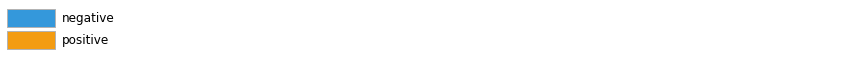

In [7]:
# get marker positive stained image

stain_nuclei, stain_cell = cytof_img.vis_marker_positive(marker="CD19", feature_type="scaled", 
                                                         accumul_type="sum", normq=99,
                                                        color_list=[(52/255,152/255,219/255), (243/255,156/255,18/255)], 
                                                         color_bound=(0,0,0)#(1,1,1)
                                                        )

# stain_nuclei_, stain_cell_ = cytof_img.vis_marker_positive(marker="CD19", feature_type="scaled", 
#                                                            accumul_type="sum", normq=99, show_boundary=False)

Visualizing channels: CD19(Nd142Di), nuclei
Visualizing... 
CD19(Nd142Di) in red
nuclei in green



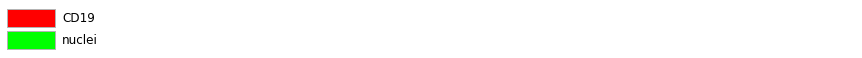

In [8]:
## Get the visualization image w/ selected channels
vis_channel_names = ['CD19(Nd142Di)', 'nuclei']#,'CD8(Dy162Di)',
#                      'CD4(Gd156Di)','Ki-67(Er168Di)','AE1-AE3(Nd148Di)']

pseudoRGB, quantiles, color_pool, fig_color_tb = cytof_img.visualize_channels(channel_names=vis_channel_names, 
                                        visualize=False)

## adjust brightness of channels
# adjust brightness of the red channel
pseudoRGB[..., 0] = np.array(np.clip(pseudoRGB[..., 0] / np.quantile(pseudoRGB[..., 0].reshape(-1), 0.95), 
                           0, 1) * 255, dtype=np.uint8)
# adjust brightness of the green channel
pseudoRGB[..., 1] = np.array(np.clip(pseudoRGB[..., 1] * 0.9, 0, 255), dtype=np.uint8)

(-0.5, 299.5, 299.5, -0.5)

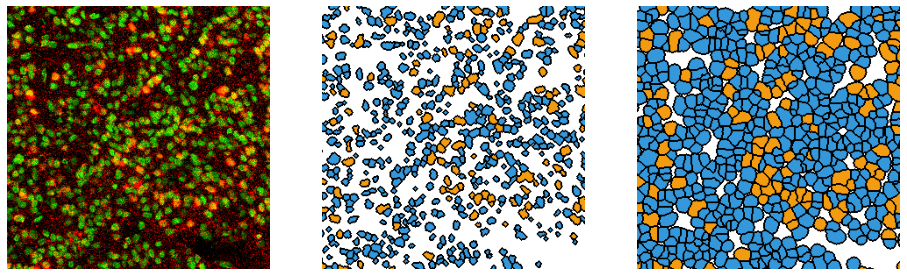

In [9]:
fig, axs = plt.subplots(1,3,figsize=(16, 8))
axs[0].imshow(pseudoRGB[0:300, 600:900, :])
axs[0].axis('off')
axs[1].imshow(stain_nuclei[0:300, 600:900, :])
axs[1].axis('off')
axs[2].imshow(stain_cell[0:300, 600:900, :])
axs[2].axis('off')

In [10]:
feat_name = "99normed_scaled"

df_marker_positive = getattr(cytof_img, "df_marker_positive_{}".format(feat_name))

(-0.5, 299.5, 299.5, -0.5)

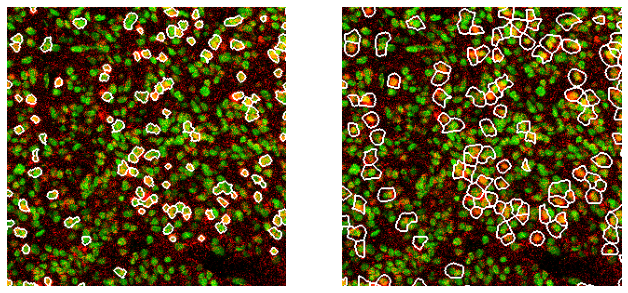

In [11]:
# mark boundaries for positive cells
from skimage.segmentation import mark_boundaries

# stained Nuclei image
color_ids = []
postive_ids = df_marker_positive.loc[df_marker_positive.loc[:, marker] == 1, "cell_id"].values
nuclei_seg = np.ones_like(cytof_img.nuclei_seg)
cell_seg = np.ones_like(cytof_img.cell_seg)
v0 = 2
for i in range(2, np.max(cytof_img.nuclei_seg) + 1):
    color_id = df_marker_positive[marker][df_marker_positive['cell_id'] == i].values[0]
#     if color_id not in color_ids:
#         color_ids.append(color_id)
    if color_id == 1: # positive
        nuclei_seg[cytof_img.nuclei_seg == i] = v0
        cell_seg[cytof_img.cell_seg == i] = v0
        v0 += 1
#     stain_nuclei[self.nuclei_seg == i] = color_list[color_id][:3]

temp_nuclei = mark_boundaries(pseudoRGB, nuclei_seg, mode="inner", color=(1,1,1))
temp_cell = mark_boundaries(pseudoRGB, cell_seg, mode="inner", color=(1,1,1))

fig, axs = plt.subplots(1,2,figsize=(11, 8))
axs[0].imshow(temp_nuclei[0:300, 600:900, :])
axs[0].axis('off')
axs[1].imshow(temp_cell[0:300, 600:900, :])
axs[1].axis('off')

#### All ROIs

In [12]:
# dir_vis_marker_positive = os.path.join(params.outdir, "vis_marker_pos")
# if not os.path.exists(dir_vis_marker_positive):
#     os.makedirs(dir_vis_marker_positive)
    
# for f in glob.glob(os.path.join(params.outdir, "cytof_images", "*.pkl")):
#     cytof_img = load_saved_CytofImage(f) #pkl.load(open(f, "rb"))
#     f_roi = f.split("/")[-1].split(".pkl")[0]
#     ## Get the visualization image w/ selected channels
#     vis_channel_names = ['CD19(Nd142Di)', 'nuclei']

#     pseudoRGB, quantiles, color_pool, fig_color_tb = cytof_img.visualize_channels(channel_names=vis_channel_names, 
#                                             visualize=False)
    
#     accumul_type = "sum"
#     stain_nuclei_agg, stain_cell_agg = cytof_img.vis_marker_positive(marker=marker,
#                                                                               feature_type=params.feature_type, 
#                                                                               accumul_type=accumul_type, 
#                                                                               normq=params.normq, 
#                                                                               color_list=[(52/255,152/255,219/255), (243/255,156/255,18/255)], 
#                                                                               color_bound=(0,0,0))
#     fig, axs = plt.subplots(1,3,figsize=(16, 8))
#     try:
#         axs[0].imshow(pseudoRGB[0:300, 600:900, :])
#         axs[0].axis('off')
#         axs[1].imshow(stain_nuclei[0:300, 600:900, :])
#         axs[1].axis('off')
#         axs[2].imshow(stain_cell[0:300, 600:900, :])
#         axs[2].axis('off')
#     except:
#         axs[0].imshow(pseudoRGB[0:100, 0:100, :])
#         axs[0].axis('off')
#         axs[1].imshow(stain_nuclei[0:100, 0:100, :])
#         axs[1].axis('off')
#         axs[2].imshow(stain_cell[0:100, 0:100, :])
#         axs[2].axis('off')
#     plt.savefig(os.path.join(dir_vis_marker_positive, "{}_{}.png".format(f_roi, accumul_type)))
#     plt.close("all")
    
#     accumul_type = "ave"
#     stain_nuclei_agg, stain_cell_agg = cytof_img.vis_marker_positive(marker=marker, 
#                                                                               feature_type=params.feature_type, 
#                                                                               accumul_type=accumul_type, 
#                                                                               normq=params.normq, 
#                                                                               color_list=[(52/255,152/255,219/255), (243/255,156/255,18/255)], 
#                                                                               color_bound=(0,0,0))#(1,1,1))
#     fig, axs = plt.subplots(1,3,figsize=(16, 8))
#     try:
#         axs[0].imshow(pseudoRGB[0:300, 600:900, :])
#         axs[0].axis('off')
#         axs[1].imshow(stain_nuclei[0:300, 600:900, :])
#         axs[1].axis('off')
#         axs[2].imshow(stain_cell[0:300, 600:900, :])
#         axs[2].axis('off')
#     except:
#         axs[0].imshow(pseudoRGB[0:100, 0:100, :])
#         axs[0].axis('off')
#         axs[1].imshow(stain_nuclei[0:100, 0:100, :])
#         axs[1].axis('off')
#         axs[2].imshow(stain_cell[0:100, 0:100, :])
#         axs[2].axis('off')
#     plt.savefig(os.path.join(dir_vis_marker_positive, "{}_{}.png".format(f_roi, accumul_type)))
#     plt.close("all")

## Gene co-expression analysis
A co-expression network identifies which genes have a tendency to show a coordinated expression pattern across a group of samples. This co-expression network can be represented as a gene–gene similarity matrix, which can be used in downstream analyses. 

99normed_scaled
NP37646_B5_TM14MAR20_NP37646_B5_ROI_005_5.pkl not found, skip
NP37646_B5_TM14MAR20_NP37646_B5_ROI_006_6.pkl not found, skip
NP37646_B5_TM14MAR20_NP37646_B5_ROI_001_1.pkl not found, skip
NP37646_B5_TM14MAR20_NP37646_B5_ROI_004_4.pkl not found, skip


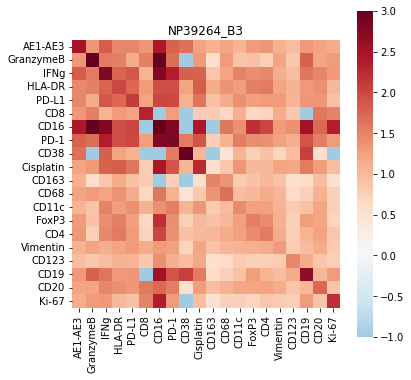

<Figure size 432x288 with 0 Axes>

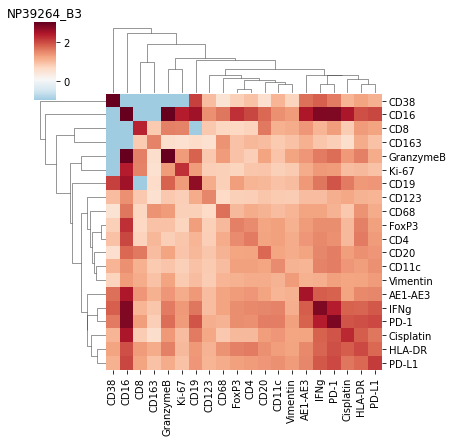

<Figure size 432x288 with 0 Axes>

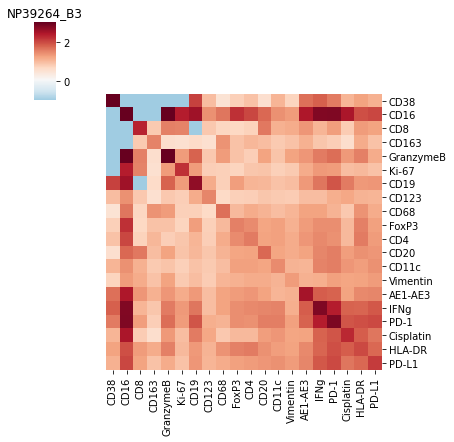

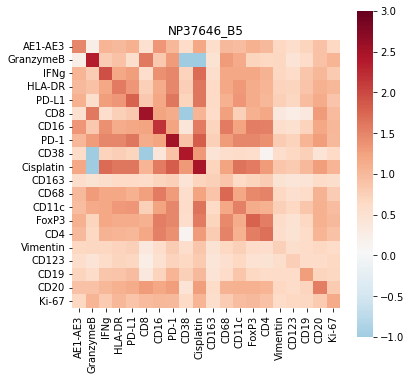

<Figure size 432x288 with 0 Axes>

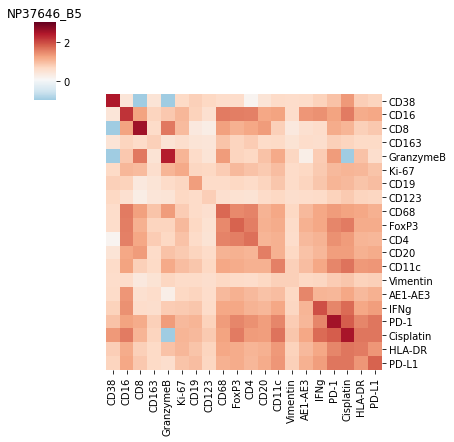

In [19]:
accumul_type="sum"
# dir_cytof_image = os.path.join(params.outdir, "cytof_images")

params.cohort_file = "../test_data/test_cohort.csv"

df_slide_roi = pd.read_csv(params.cohort_file)
co_exp_markers = ['AE1-AE3', 'GranzymeB', 'IFNg', 'HLA-DR', 'PD-L1', 'CD8', 'CD16',  'PD-1', 'CD38', 'Cisplatin', 
 'CD163','CD68','CD11c','FoxP3','CD4', 'Vimentin','CD123', 'CD19', 'CD20', 'Ki-67']

# df_io = pd.read_csv(os.path.join(params.outdir, "input_output.csv"))

co_exps, marker_idx, clustergrid = co_expression_analysis(df_slide_roi, 
                                                          outdir=params.outdir, 
                                                          feature_type=params.feature_type, 
                                                          accumul_type=accumul_type, 
                                                          co_exp_markers=co_exp_markers, 
                                                          normq=params.normq, 
                                                          level="slide", 
                                                          clustergrid=None)

## 9) Marker Correlation Analysis

99normed_scaled
NP37646_B5_TM14MAR20_NP37646_B5_ROI_005_5.pkl not found, skip
NP37646_B5_TM14MAR20_NP37646_B5_ROI_006_6.pkl not found, skip
NP37646_B5_TM14MAR20_NP37646_B5_ROI_001_1.pkl not found, skip
NP37646_B5_TM14MAR20_NP37646_B5_ROI_004_4.pkl not found, skip


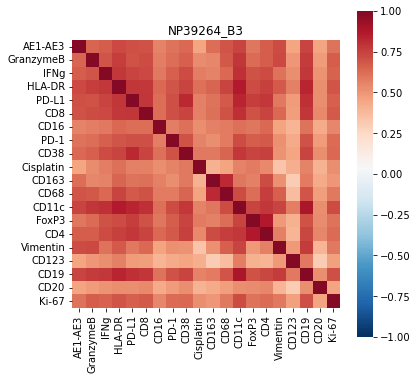

<Figure size 432x288 with 0 Axes>

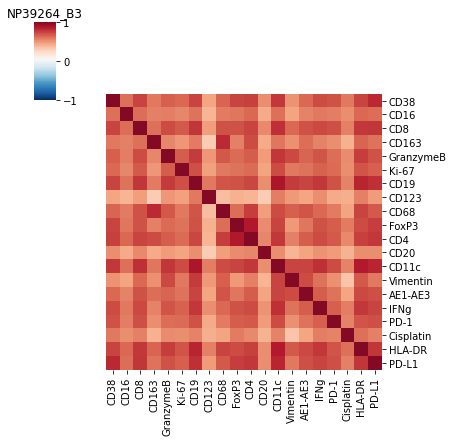

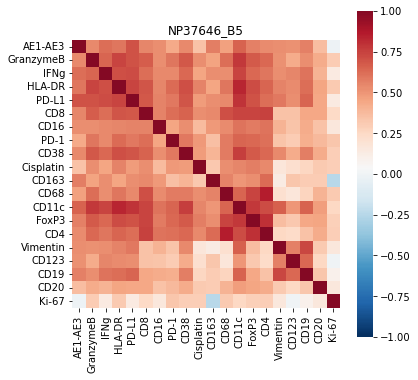

<Figure size 432x288 with 0 Axes>

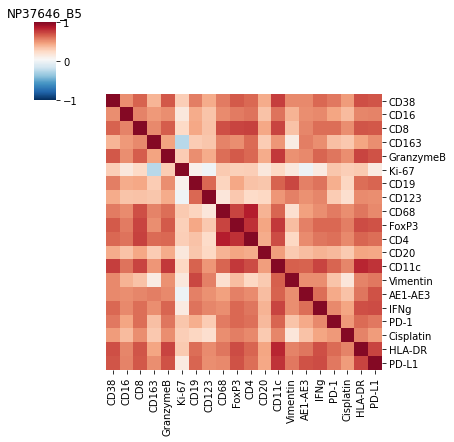

In [28]:
corr_markers = co_exp_markers

# corrs = correlation_analysis(df_slide_roi, outdir=params.outdir, feature_type=params.feature_type, 
#                        accumul_type=accumul_type, corr_markers=co_exp_markers, normq=params.normq, level="slide")

corrs, marker_idx, clustergrid = correlation_analysis(df_slide_roi, outdir=params.outdir, feature_type=params.feature_type, 
                                                       accumul_type=accumul_type, corr_markers=co_exp_markers, normq=params.normq, 
                                                       level="slide",#"roi"
                                                       clustergrid=clustergrid
                                                      )

## 10) Marker Interaction Analysis

99normed_scaled
NP37646_B5_TM14MAR20_NP37646_B5_ROI_005_5.pkl not found, skip
NP37646_B5_TM14MAR20_NP37646_B5_ROI_006_6.pkl not found, skip
NP37646_B5_TM14MAR20_NP37646_B5_ROI_001_1.pkl not found, skip
NP37646_B5_TM14MAR20_NP37646_B5_ROI_004_4.pkl not found, skip


100%|██████████████████████████████████████████████████████████| 5003/5003 [00:09<00:00, 538.72it/s]


NP37646_B5_TM14MAR20_NP37646_B5_ROI_005_5.pkl not found, skip
NP37646_B5_TM14MAR20_NP37646_B5_ROI_006_6.pkl not found, skip
NP37646_B5_TM14MAR20_NP37646_B5_ROI_001_1.pkl not found, skip


100%|██████████████████████████████████████████████████████████| 3574/3574 [00:04<00:00, 762.07it/s]


NP37646_B5_TM14MAR20_NP37646_B5_ROI_004_4.pkl not found, skip


100%|██████████████████████████████████████████████████████████| 3363/3363 [00:04<00:00, 813.06it/s]


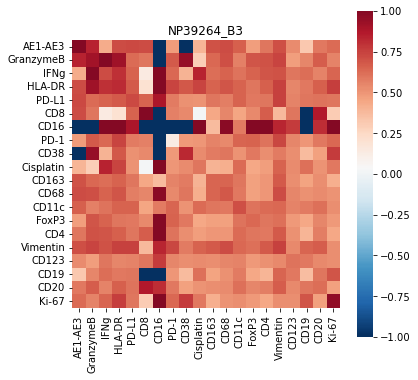

<Figure size 432x288 with 0 Axes>

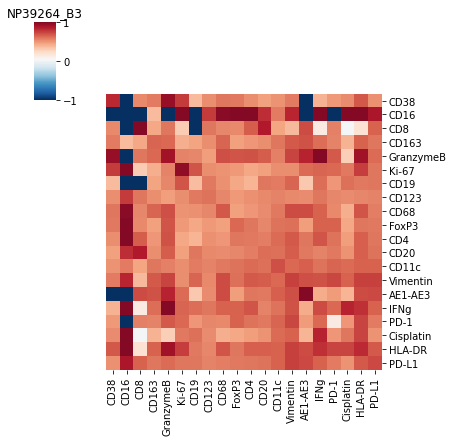

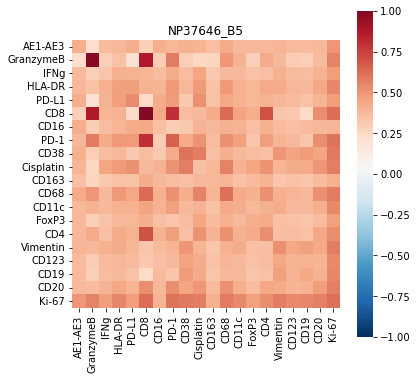

<Figure size 432x288 with 0 Axes>

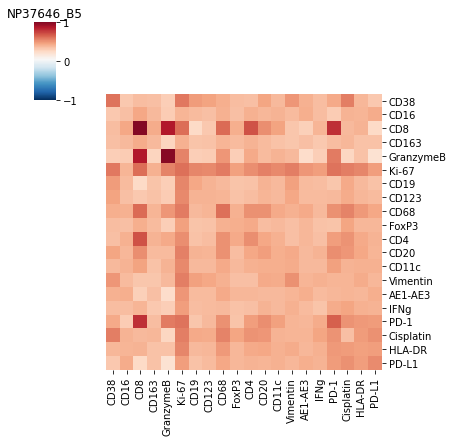

In [37]:
interact_markers = co_exp_markers

interacts, cluster_grid = interaction_analysis(df_slide_roi, outdir=params.outdir, 
                                 feature_type=params.feature_type, 
                                 accumul_type=accumul_type, 
                                 interact_markers=interact_markers, 
                                 normq=params.normq, level="slide", #"roi", #
                                 thres_dist=50, clustergrid=clustergrid)